In [1]:
from simtk import unit
from simtk import openmm

import numpy as np
from sys import stdout
from openmmtools import integrators
import random
import matplotlib.pyplot as plt

Defines system for use in BG and in MD simulation, can create from scratch as commented out

In [2]:
# pdb = app.PDBFile('ala2_fromURL.pdb')
# topology = pdb.getTopology()
# positions = pdb.getPositions(asNumpy=True).value_in_unit(unit.nanometer)

# ff = app.ForceField('amber99sbildn.xml',"amber96_obc.xml")
# system = ff.createSystem(
#     topology=topology, 
#     removeCMMotion=True,
#     nonbondedMethod=app.NoCutoff,
#     constraints=app.HBonds, 
#     rigidWater=True
#     )

with open('Alanine_dipeptide/ala2_noconstraints_system.txt') as f:
    xml = f.read()
noconstr_system = openmm.XmlSerializer.deserialize(xml)
#platform 2 = CUDA
platform = openmm.Platform.getPlatform(2)

temperature_bg = 300.0 * unit.kelvin
collision_rate_bg = 1.0 / unit.picosecond
timestep_bg = 4.0 * unit.femtosecond

In [3]:
#Setting up generator
import torch

device = "cuda:1" if torch.cuda.is_available() else "cpu"
dtype = torch.float32
# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

#need to load a dataset for dimensions of BG and to set up Mixed Coordinate Transform which requires data as an argument
import mdtraj
rough_dataset = mdtraj.load('Alanine_dipeptide/Trajectories/TSFtraj.dcd', top='Alanine_dipeptide/ala2_fromURL.pdb', stride=10)
dataset = rough_dataset.superpose(rough_dataset[0])

import numpy as np
rigid_block = np.array([6, 8, 9, 10, 14])
z_matrix = np.array([
    [0, 1, 4, 6],
    [1, 4, 6, 8],
    [2, 1, 4, 0],
    [3, 1, 4, 0],
    [4, 6, 8, 14],
    [5, 4, 6, 8],
    [7, 6, 8, 4],
    [11, 10, 8, 6],
    [12, 10, 8, 11],
    [13, 10, 8, 11],
    [15, 14, 8, 16],
    [16, 14, 8, 6],
    [17, 16, 14, 15],
    [18, 16, 14, 8],
    [19, 18, 16, 14],
    [20, 18, 16, 19],
    [21, 18, 16, 19]
])

def dimensions(dataset):
        return np.prod(dataset.xyz[0].shape)
dim = dimensions(dataset)

#system setup, probably need to write a function to do this
# from simtk import openmm
# with open('ala2_xml_system.txt') as f:
#     xml = f.read()
# system = openmm.XmlSerializer.deserialize(xml)
from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy

integrator = integrators.LangevinIntegrator(temperature=temperature_bg,collision_rate=collision_rate_bg,timestep=timestep_bg)
energy_bridge = OpenMMBridge(noconstr_system, integrator, n_workers=1)
target_energy = OpenMMEnergy(int(dim), energy_bridge)

#setting up training_data argument for MixedCoordinateTransform - not sure how much effect this has
n_train = len(dataset)//2
n_test = len(dataset) - n_train
permutation = np.random.permutation(n_train)
all_data = dataset.xyz.reshape(-1, dimensions(dataset))
training_data = torch.tensor(all_data[permutation]).to(ctx)
test_data = torch.tensor(all_data[permutation + n_train]).to(ctx)

import bgflow as bg

dim_cartesian = len(rigid_block) * 3 - 6
dim_bonds = len(z_matrix)
dim_angles = dim_bonds
dim_torsions = dim_bonds

#set up coordinate transform layer
coordinate_transform = bg.MixedCoordinateTransformation(
    data=training_data, 
    z_matrix=z_matrix,
    fixed_atoms=rigid_block,
    keepdims=dim_cartesian, 
    normalize_angles=True,
).to(ctx)

#setting up prior distribution
dim_ics = dim_bonds + dim_angles + dim_torsions + dim_cartesian
mean = torch.zeros(dim_ics).to(ctx) 
# passing the mean explicitly to create samples on the correct device
prior = bg.NormalDistribution(dim_ics, mean=mean)

split_into_ics_flow = bg.SplitFlow(dim_bonds, dim_angles, dim_torsions, dim_cartesian)

#defining RealNVP
class RealNVP(bg.SequentialFlow):
    
    def __init__(self, dim, hidden):
        self.dim = dim
        self.hidden = hidden
        super().__init__(self._create_layers())
    
    def _create_layers(self):
        dim_channel1 =  self.dim//2
        dim_channel2 = self.dim - dim_channel1
        split_into_2 = bg.SplitFlow(dim_channel1, dim_channel2)
        
        layers = [
            # -- split
            split_into_2,
            # --transform
            self._coupling_block(dim_channel1, dim_channel2),
            bg.SwapFlow(),
            self._coupling_block(dim_channel2, dim_channel1),
            # -- merge
            bg.InverseFlow(split_into_2)
        ]
        return layers
        
    def _dense_net(self, dim1, dim2):
        return bg.DenseNet(
            [dim1, *self.hidden, dim2],
            activation=torch.nn.ReLU()
        )
    
    def _coupling_block(self, dim1, dim2):
        return bg.CouplingFlow(bg.AffineTransformer(
            shift_transformation=self._dense_net(dim1, dim2),
            scale_transformation=self._dense_net(dim1, dim2)
        ))

#setting up normalising flow composed of RealNVP followed by coordinate transform
n_realnvp_blocks = 5
layers = []

for i in range(n_realnvp_blocks):
    layers.append(RealNVP(dim_ics, hidden=[128, 128, 128]))
layers.append(split_into_ics_flow)
layers.append(bg.InverseFlow(coordinate_transform))

flow = bg.SequentialFlow(layers).to(ctx)

#loading trained model into empty
flow.load_state_dict(torch.load('Alanine_dipeptide/Models/model300K_noconstr_long_1.pt'))

#setting up generator
generator = bg.BoltzmannGenerator(
    flow=flow,
    prior=prior,
    target=target_energy)

In [4]:
#generator_new = bg.BoltzmannGenerator()

In [4]:
def getbg_positions(n_atoms):    
    bg_positions_tensor, dlogp_tensor = generator.sample(1,with_dlogp=True)
    bg_positions = bg_positions_tensor.cpu().detach().numpy().reshape(n_atoms,3)
    dlogp = dlogp_tensor.cpu().detach().numpy()
    #return bg_positions, np.exp(np.abs(dlogp))
    #return bg_positions, dlogp
    return bg_positions, np.abs(dlogp)
#print(bg_positions, dlogp)


In [5]:
def getbias(positions,n_atoms):
    torch_positions = torch.tensor(positions.reshape(-1,n_atoms*3)).to(ctx)
    z, dlogp_inverse_tensor = flow.forward(torch_positions,inverse=True)
    dlogp_inverse = dlogp_inverse_tensor.cpu().detach().numpy()
    #return np.exp(np.abs(dlogp_inverse))
    return np.abs(dlogp_inverse)
    #return -dlogp_inverse

In [7]:
positions = generator.sample(1).cpu().detach().numpy().reshape(22,3)

print(getbias(positions,22))

[[334.7126]]


In [6]:
def getthermalenergy(temperature):
    #unit.BOLTZMANN_CONSTANT_kB is in units of J/K
    kb = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
    kt = kb * temperature
    kt = kt.value_in_unit(unit.kilojoule_per_mole)
    beta = 1/kt
    return beta

In [9]:
print(getthermalenergy(300*unit.kelvin))

0.40090785014242025


In [19]:
cycles = 100
MDsteps = 1000
BGmoves = 500

fname = 'coupled'

In [20]:
##Setting up MD and initialising

pdb = openmm.app.PDBFile('Alanine_dipeptide/ala2_fromURL.pdb')
topology = pdb.getTopology()
positions = pdb.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
n_atoms = positions.shape[0]

#reference frame for aligning all the MD conformations before pushing back through the flow to find the bias. Should come from BG training dataset - usually the first frame
reference_frame = mdtraj.load('Alanine_dipeptide/Trajectories/300K.dcd',top='Alanine_dipeptide/ala2_fromURL.pdb')[0]

md_temperature = 300 * unit.kelvin
md_collision_rate = 10 / unit.picosecond
md_timestep = 1.0 * unit.femtosecond

parametersdict = {'Collision rate':md_collision_rate,'Temperature':md_temperature,'Timestep':md_timestep}
import pickle
with open(f'Alanine_dipeptide/parameters/parameters{fname}.pkl','wb') as f_p:
    pickle.dump(parametersdict,f_p)
f_p.close

integrator = integrators.LangevinIntegrator(temperature=md_temperature,collision_rate=md_collision_rate,timestep=md_timestep)
#integrator.setConstraintTolerance(0.00001)
#integrator = openmm.VerletIntegrator(timestep)
properties_dict = {}
properties_dict["DeviceIndex"] = "2"
simulation = openmm.app.Simulation(topology, noconstr_system, integrator,platform,platformProperties=properties_dict)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(md_temperature)
#simulation.reporters.append(openmm.app.DCDReporter(f'{fname}.dcd',100))
simulation.step(1000)
#simulation.reporters.pop(-1)

In [21]:
##WITH BIAS

#reporter for details about states - kinetic energy etc.
textfile_reporter = openmm.app.StateDataReporter(
    f'Coupled_scheme/Trajectories/{fname}.txt', 
    reportInterval=100, 
    step=True, 
    potentialEnergy=True,
    kineticEnergy = True,
    totalEnergy = True,
    temperature=True,
)

simulation.reporters.append(textfile_reporter)

#reporter to watch progress of simulation - to stdout
simulation.reporters.append(openmm.app.StateDataReporter(
    stdout, 
    reportInterval=100, 
    step=True, 
    totalEnergy = True,
    temperature=True,
))

#reporter for trajectory - positions
trajectory_reporter = openmm.app.DCDReporter(f'Coupled_scheme/Trajectories/{fname}.dcd',reportInterval=100)
simulation.reporters.append(trajectory_reporter)

accept_counter = 0
acceptance_probs = []
biases = []

for x in range(cycles):
    print('cycle',x)
    simulation.step(MDsteps)
    current_state = simulation.context.getState(getEnergy=True,getPositions=True)
    current_positions = current_state.getPositions(asNumpy=True)
    current_positions_astraj = mdtraj.Trajectory(xyz=current_positions, topology=mdtraj.load('Alanine_dipeptide/ala2_fromURL.pdb').topology)
    current_positions_aligned = current_positions_astraj.superpose(reference_frame).xyz
    bias_current = getbias(current_positions_aligned,n_atoms=n_atoms)
    biases.append(bias_current[0,0])
    current_total_energy = current_state.getKineticEnergy() + current_state.getPotentialEnergy()
    print('MD_end_energy',current_total_energy)
    for y in range(BGmoves):  
        integrator = integrators.LangevinIntegrator(temperature=md_temperature,collision_rate=md_collision_rate,timestep=md_timestep)
        bgsimulation = openmm.app.Simulation(topology,noconstr_system,integrator,platform,platformProperties=properties_dict)
        bg_positions, bias_new = getbg_positions(n_atoms=n_atoms)
        bgsimulation.context.setPositions(bg_positions)
        bgsimulation.context.setVelocitiesToTemperature(md_temperature)
        new_state = bgsimulation.context.getState(getEnergy=True,getPositions=True)
        # only use this reporter if not breaking loop when new BG conformation is accepted
        # openmm.app.DCDReporter('coupled_BGonly.dcd',100, append=True).report(bgsimulation,new_state)
        new_total_energy = new_state.getKineticEnergy() + new_state.getPotentialEnergy()
        energy_change = (new_total_energy - current_total_energy).value_in_unit(unit.kilojoule_per_mole)
        bias_change = bias_current-bias_new
        #acceptance_prob = min(1,(np.exp(bias_change-getthermalenergy(md_temperature)*energy_change)))
        acceptance_prob = min(1,(np.exp(-getthermalenergy(md_temperature)*energy_change)))#*bias_current/bias_new))
        acceptance_probs.append(acceptance_prob)
        random_val = random.random()
        if random_val < acceptance_prob:
            print('accept new conformation')
            print('accepted BG energy',new_total_energy)
            new_checkpoint = bgsimulation.context.createCheckpoint()
            simulation.context.loadCheckpoint(new_checkpoint)
            BG_state = simulation.context.getState(getEnergy=True,getPositions=True)
            trajectory_reporter.report(simulation,BG_state)
            textfile_reporter.report(simulation,BG_state)
            accept_counter += 1
            break
        else:
            print('rejected BG energy',y,new_total_energy)
        #simulation.context.setVelocitiesToTemperature(md_temperature)


cycle 0
#"Step","Total Energy (kJ/mole)","Temperature (K)"
1100,-3.30230712890625,247.09413938953662
1200,-1.9038314819335938,246.45877786381345
1300,-1.984832763671875,220.96505321967092
1400,3.4139022827148438,188.0047601088256
1500,39.50287628173828,252.02173783099963
1600,2.676727294921875,239.51151570672818
1700,11.264968872070312,296.74881803342737
1800,14.14837646484375,328.0827359509001
1900,22.472434997558594,243.55128009285264
2000,4.458717346191406,241.50697212200308
MD_end_energy 4.458717346191406 kJ/mol
rejected BG energy 0 545.1581192016602 kJ/mol
rejected BG energy 1 26.12896728515625 kJ/mol
rejected BG energy 2 83.49945449829102 kJ/mol
rejected BG energy 3 312.3249282836914 kJ/mol
rejected BG energy 4 30.200584411621094 kJ/mol
rejected BG energy 5 59.913421630859375 kJ/mol
rejected BG energy 6 88.93282318115234 kJ/mol
rejected BG energy 7 27.51677703857422 kJ/mol
rejected BG energy 8 106.40928649902344 kJ/mol
rejected BG energy 9 44.53760528564453 kJ/mol
rejected BG ene

KeyboardInterrupt: 

In [ ]:
##ALTERED VERSION WITH POT. ENERGY COMPARISON
simulation.reporters.append(openmm.app.StateDataReporter(
    f'{fname}.txt', 
    reportInterval=100, 
    step=True, 
    potentialEnergy=True,
    kineticEnergy = True,
    totalEnergy = True,
    temperature=True,
))
simulation.reporters.append(openmm.app.StateDataReporter(
    stdout, 
    reportInterval=100, 
    step=True, 
    totalEnergy = True,
    temperature=True,
))
simulation.reporters.append(openmm.app.DCDReporter(f'{fname}.dcd',reportInterval=100))#, #append=True))

for x in range(cycles):
    print('cycle',x)
    simulation.step(MDsteps)
    current_state = simulation.context.getState(getEnergy=True,getPositions=True)
    current_positions = current_state.getPositions(asNumpy=True)
    current_positions_astraj = mdtraj.Trajectory(xyz=current_positions, topology=mdtraj.load('ala2_fromURL.pdb').topology)
    current_positions_aligned = current_positions_astraj.superpose(reference_frame).xyz
    bias_current = getbias(current_positions_aligned,n_atoms=n_atoms)
    #MDkinetic_energies.append(current_state.getKineticEnergy())
    #MDpotential_energies.append(current_state.getPotentialEnergy())
    current_pot_energy = current_state.getPotentialEnergy()
    print('MD_end_energy',current_pot_energy)
    for y in range(BGmoves):  
        integrator = integrators.LangevinIntegrator(temperature=md_temperature,collision_rate=md_collision_rate,timestep=md_timestep)
        bgsimulation = openmm.app.Simulation(topology,system,integrator,platform,platformProperties=properties_dict)
        bg_positions, bias_new = getbg_positions(n_atoms=n_atoms)
        bgsimulation.context.setPositions(bg_positions)
        new_state = bgsimulation.context.getState(getEnergy=True,getPositions=True)
        new_pot_energy = new_state.getPotentialEnergy()
        #print('new_tot_energy',new_total_energy)
        energy_change = (new_pot_energy - current_pot_energy).value_in_unit(unit.kilojoule_per_mole)
        acceptance_prob = min(1,(np.exp(-getthermalenergy(md_temperature)*energy_change)))#*bias_current/bias_new))
        random_val = random.random()
        if random_val < acceptance_prob:
            print('accept new conformation')
            print('accepted BG energy',new_pot_energy)
            #openmm.app.StateDataReporter(stdout,reportInterval=100, step=True, potentialEnergy=True,temperature=True).report(bgsimulation,new_state)
            new_checkpoint = bgsimulation.context.createCheckpoint()
            simulation.context.loadCheckpoint(new_checkpoint)
            #simulation.context.getState(getPositions=True)
            #openmm.app.DCDReporter('coupled.dcd',100, append=True).report(simulation,)
            break
        else:
            print('rejected BG energy',y,new_pot_energy)


In [ ]:
integrator = integrators.LangevinIntegrator(temperature=md_temperature,collision_rate=md_collision_rate,timestep=md_timestep)
bgsimulation = openmm.app.Simulation(topology,system,integrator,platform,platformProperties=properties_dict)
bg_positions, bias_new = getbg_positions(n_atoms=n_atoms)
bgsimulation.context.setPositions(bg_positions)
new_state = bgsimulation.context.getState(getEnergy=True,getPositions=True)
new_pot_energy = new_state.getPotentialEnergy()
#print('new_tot_energy',new_total_energy)
energy_change = (new_pot_energy - current_pot_energy).value_in_unit(unit.kilojoule_per_mole)
acceptance_prob = min(1,(np.exp(-getthermalenergy(md_temperature)*energy_change)))#*bias_current/bias_new))
random_val = random.random()
if random_val < acceptance_prob:
    print('accept new conformation')
    print('accepted BG energy',new_pot_energy)
    #openmm.app.StateDataReporter(stdout,reportInterval=100, step=True, potentialEnergy=True,temperature=True).report(bgsimulation,new_state)
    new_checkpoint = bgsimulation.context.createCheckpoint()
    simulation.context.loadCheckpoint(new_checkpoint)

In [15]:
print(accept_counter /(BGmoves*cycles))
print(np.average(acceptance_probs))
#print(np.average(BGkinetic_energies))
#print(np.average(BGpotential_energies))

0.212
0.21275595247533396


In [12]:
import mdtraj as md

#traj = md.load('pro_trajectory.dcd',top=md.Topology.from_openmm(topology))
traj = md.load('coupled.dcd',top='ala2_fromURL.pdb')
print
#print(traj[24].xyz)
import nglview
view = nglview.show_mdtraj(traj)
view

In [ ]:
reference_frame = mdtraj.load('TSFtraj.dcd',top='ala2_fromURL.pdb')[0]

In [ ]:
simulation.step(MDsteps)
current_state = simulation.context.getState(getEnergy=True,getPositions=True)
current_positions = current_state.getPositions(asNumpy=True)
current_positions_astraj = mdtraj.Trajectory(xyz=current_positions, topology=mdtraj.load('ala2_fromURL.pdb').topology)
current_positions_aligned = current_positions_astraj.superpose(reference_frame).xyz
bias_current = getbias(current_positions_aligned)
print(bias_current)
current_total_energy = current_state.getKineticEnergy() + current_state.getPotentialEnergy()
print('MD_end_energy',current_total_energy)

In [ ]:
#current_positions = current_state.getPositions(asNumpy=True)
torch_positions = torch.tensor(current_positions_aligned.reshape(-1,66)).to(ctx)

z = flow.forward(torch_positions,inverse=True)
x_out = flow.forward(z[0])
z_2 = flow.forward(x_out[0],inverse=True)
x_2 = flow.forward(z_2[0])
z_3 = flow.forward(x_out[0],inverse=True)
x_3 = flow.forward(z_3[0])
print('initial_x',torch_positions)
print('z 1',z)
print('x_out',x_out)
print('z 2',z_2)
print('x_2',x_2)
print('z 3',z_3)
print('x_3',x_3)

In [ ]:
bg_positions, z = generator.sample(1, with_latent=True)
z_from_inverse = flow.forward(bg_positions, inverse=True)

print(bg_positions)
print(z)
print(z_from_inverse)

x_new = flow.forward(z_from_inverse[0])
x_fromlatent = flow.forward(z)

print(x_new)
print(x_fromlatent)

In [ ]:
BG_cartesian = generator.sample(1000)

MDTSF_traj = mdtraj.load('TSFtraj.dcd',top='ala2_fromURL.pdb',stride=1000)
MDTSF_cartesian = torch.tensor(MDTSF_traj.xyz.reshape(-1,66)).to(ctx)

MD3000K_traj = mdtraj.load('3000K.dcd',top='ala2_fromURL.pdb',stride=100)
MD3000K_cartesian = torch.tensor(MD3000K_traj.xyz.reshape(-1,66)).to(ctx)

BG300K_traj = mdtraj.load('TSFtraj_xmlsystem_20000KLL_samplestraj.dcd',top='ala2_fromURL.pdb',stride=10)
BG300K_cartesian = torch.tensor(BG300K_traj.xyz.reshape(-1,66)).to(ctx)

MD300K_superposed_traj = MD300K_traj.superpose(MD300K_traj[0])
MD300K_superposed_cartesian = torch.tensor(MD300K_superposed_traj.xyz.reshape(-1,66)).to(ctx)

MD1000K_traj = mdtraj.load('1000K_2.dcd',top='ala2_fromURL.pdb',stride=100)
MD1000K_cartesian = torch.tensor(MD1000K_traj.xyz[0:1000].reshape(-1,66)).to(ctx)

MD1000K_superposed_traj = MD1000K_traj.superpose(MD1000K_traj[0])
MD1000K_superposed_cartesian = torch.tensor(MD300K_superposed_traj.xyz.reshape(-1,66)).to(ctx)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
means = {}
dist_from_means = {}
cartesian_sets = {'BG 20000KLL on 1000 K traj': BG_cartesian,
            'MD TSF': MDTSF_cartesian,
            #'MD1000K' : MD1000K_cartesian,
            #'MD300K superposed' : MD300K_superposed_cartesian,
            'MD1000K superposed' : MD1000K_superposed_cartesian,
            #'MD non superposed 3000 K' : MD3000K_cartesian,
            'BG 20000 KLL trained TSF trajectory' : BG300K_cartesian
            }

names_list = list(cartesian_sets)
for name, cartesian_data in cartesian_sets.items():
    means[name] = torch.mean(cartesian_data, dim = 0)
    dist_from_means[name] = torch.sub(cartesian_data, means[name])
    ax.hist(dist_from_means[name].flatten().cpu().detach().numpy(), bins = 40, label=f'{name}', alpha = (1-names_list.index(name)/5))

ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')
ax.set_xlabel("Distance from mean, Cartesian space")
#ax.set_ylabel(f"Count   [#Samples / {len(cartesian_data[name].flatten())}]")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
latents = {}
means = {}
dist_from_means = {}
# cartesian_sets = {'BG 2000KLL trained on TSF traj': BG_cartesian,
#             #'MD300K': MD300K_cartesian,
#             #'MD1000K' : MD1000K_cartesian,
#             #'MD300K superposed' : MD300K_superposed_cartesian,
#             'MD non superposed 3000 K' : MD3000K_cartesian,
#             'BG 2000 KLL trained on superposed 3000 K' : BG3000K_cartesian
#             }

names_list = list(cartesian_sets)
for name, cartesian_data in cartesian_sets.items():
    latents[cartesian_data] = flow.forward(cartesian_data,inverse=True)[0]
    means[cartesian_data] = torch.mean(latents[cartesian_data], dim = 0)
    dist_from_means[cartesian_data] = torch.sub(latents[cartesian_data], means[cartesian_data])
    ax.hist(dist_from_means[cartesian_data].flatten().cpu().detach().numpy(), bins = 100, label=f'{name}', alpha = (1-names_list.index(name)/5))

ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')
ax.set_xlabel("Distance from mean, latent space")
#ax.set_ylabel(f"Count   [#Samples / {len(BG_cart_distfrommean.flatten())}]")

plt.show()

In [10]:
BGbiases = generator.sample(100, with_dlogp=True)[1].cpu().detach().numpy()
BGbiases_abs = [np.abs(bias[0]) for bias in BGbiases]

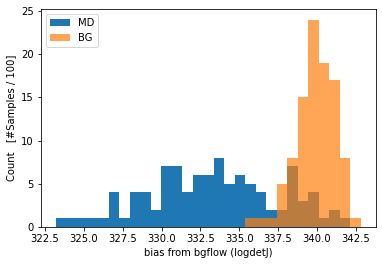

In [11]:
fig, ax = plt.subplots()

bins = np.linspace(np.min(biases), np.max(BGbiases_abs), 30)

ax.hist(biases, bins=bins, label='MD')
ax.hist(BGbiases_abs, bins=bins, label='BG', alpha=0.7)
ax.set_xlabel('bias from bgflow (logdetJ)')
ax.set_ylabel(f"Count   [#Samples / {len(biases)}]")
ax.legend()